In [2]:
import torch
import pandas as pd
import numpy as np
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyBigWig
import xarray as xr


class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
    

def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()


def get_targets(organism):
  targets_txt = f'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_{organism}.txt'
  return pd.read_csv(targets_txt, sep='\t')

In [3]:
data = torch.load("/cellar/users/aklie/opt/enformer-pytorch/data/test-sample.pt")
seq = data["sequence"].cpu().numpy()[np.newaxis, :, :]
target = data["target"].cpu().numpy()
sdata = xr.Dataset(
    data_vars=dict(
        ohe_seq=(["_sequence", "length", "_ohe"], seq),
        target=(["target_length", "_targets"], target),
        train_val=(["_sequence"], [True])
    ),
    attrs=dict(max_jitter=0),
)

In [6]:
# In case the PYTHONPATH is not set
import sys
sys.path.append('/cellar/users/aklie/opt/ml4gland/basenji2-pytorch')

In [8]:
# Import the code for loading the PyTorch model
from basenji2_pytorch import Basenji2, params # or PLBasenji2 to use training parameters from Kelley et al. 2020

# Define the path to your downloaded weights
model_weights = '/cellar/users/aklie/projects/ML4GLand/models/Basenji/basenji2.pth'  # TODO: Change this to your path

In [9]:
import json
# Open up the model config file
with open(params) as params_open:
    params = json.load(params_open)
    model_params = params['model']
    train_params = params['train']

In [10]:
# Create the model
basenji2 = Basenji2(model_params)

In [11]:
# Load the weights
basenji2.load_state_dict(torch.load(model_weights), strict=False)

<All keys matched successfully>

In [12]:
# Print the model summary
import torchinfo

torchinfo.summary(basenji2, input_size=(1, 4, 131072))

Layer (type:depth-idx)                                            Output Shape              Param #
Basenji2                                                          [1, 896, 5313]            --
├─Sequential: 1-1                                                 [1, 896, 5313]            --
│    └─Sequential: 2-1                                            [1, 1536, 896]            --
│    │    └─BasenjiConvBlock: 3-1                                 [1, 288, 65536]           17,856
│    │    └─BasenjiConvTower: 3-2                                 [1, 768, 1024]            7,720,099
│    │    └─BasenjiDilatedResidual: 3-3                           [1, 768, 1024]            13,001,472
│    │    └─Cropping1d: 3-4                                       [1, 768, 896]             --
│    │    └─BasenjiConvBlock: 3-5                                 [1, 1536, 896]            1,182,720
│    │    └─GELU: 3-6                                             [1, 1536, 896]            --
│    └─Sequential: 

In [13]:
# Send Basenji2 to CPU and capture the output
basenji2.eval();

In [23]:
# Set up the data
SEQUENCE_LENGTH = 131072
fasta_extractor = FastaStringExtractor("/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa")

In [24]:
# Get the sequence
target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
sequence_one_hot = torch.tensor(sequence_one_hot).unsqueeze(0).permute(0, 2, 1)
sequence_one_hot.shape

torch.Size([1, 4, 131072])

In [25]:
# function to clear GPU memory
import gc
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Allocated: {round(torch.cuda.memory_allocated(0)/1024**3,1)}GB")
clear_gpu_memory()

Allocated: 0.4GB


In [31]:
with torch.no_grad():
    predictions = basenji2(sequence_one_hot.cuda()).detach().cpu().numpy().squeeze()

In [33]:
predictions.shape

(896, 5313)

In [34]:
# Get h1-hesc DNase-seq signal
bw_file = "/cellar/users/aklie/data/datasets/ENCODE_examples/processed/2024_01_01/DNase-seq/H1-hESC/ENCFF573NKX.bigWig"
file = pyBigWig.open(str(bw_file))
count_vals = np.array(file.values(target_interval.chrom, target_interval.start, target_interval.end))
count_vals = np.nan_to_num(count_vals)

# Bin this into 128 wide bins by summing
count_vals = count_vals.reshape(-1, 128).sum(axis=1)
file.close()

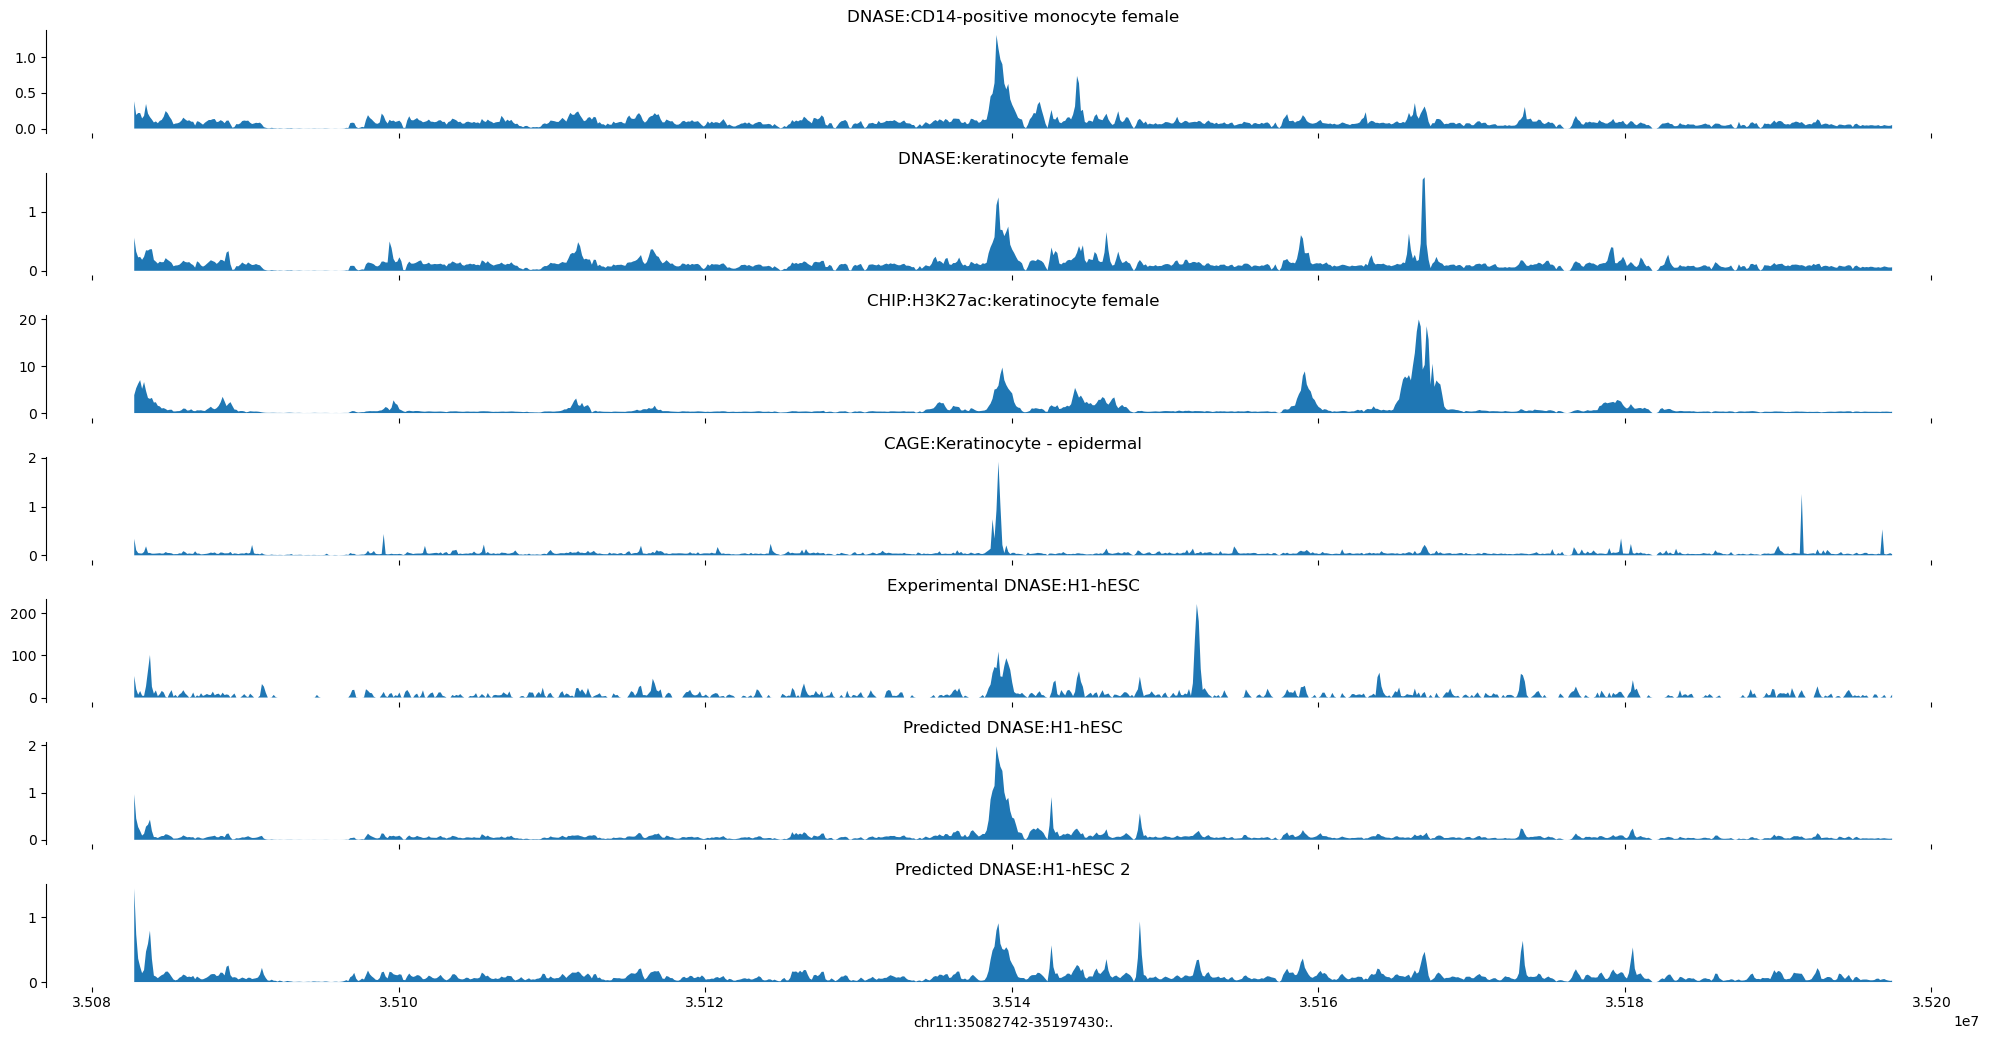

In [35]:
# @title Plot tracks
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799]),
          'Experimental DNASE:H1-hESC': count_vals,
          'Predicted DNASE:H1-hESC': predictions[:, 19],
          'Predicted DNASE:H1-hESC 2': predictions[:, 70],
          'Predicted DNASE:H1-hESC 2': predictions[:, 70],
}
plot_tracks(tracks, target_interval)

In [38]:
from scipy.stats import pearsonr

In [39]:
pearsonr(count_vals, predictions[:, 19])

PearsonRResult(statistic=0.5381754723258978, pvalue=2.0271737856476067e-68)

# DONE!

---